**Regression and Decision Tree/Crime Dataset Report**
*created by Austin Bailey, Ethan Low, Thomas Witney and Jack Wooley*

In [258]:
# DATA SLAYERS SLAYERS

import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from pandas import read_csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing
from sklearn.feature_selection import RFE, SelectFromModel, f_regression
from sklearn.preprocessing import MinMaxScaler

**Data Cleaning:**
We began by removing the first 5 columns, as these were labels and not useful features. Then we removed all columns that could be considered response variables, or contributed to our primary response: nonViolPerPop. We also decided to remove the columns that indicated the racial breakdown of the communities, as it would not be ethical to consider these as explanatory variables for crime. Next, we needed to consider how to deal with missing data, which this dataset had plenty of. If we decided to simply drop all rows with missing data, our data goes from 2215 samples to 302. However, we noticed that there were some columns that had mostly missing data. So, we decided to drop any columns that were missing over 80% of their values. Surprisingly, almost all the missing values were accounted for in the columns we dropped. After now dropping any rows with missing values, we were left with our clean data: 2118 data points with 92 explanatory variables. We found that nonViolPerPop (our response variable) was missing about 90 values. Because these rows must be dropped (we can't use them for creating a model) most of the lost samples were due to this column and couldn't be avoided. Our data went from 2215 to 2118 samples, around 90 of the rows dropped being necessary. We believe this was the best way to keep as much relevant data as possible, both in rows and columns, as it allowed us to keep the majority of our data without losing too much information.

In [284]:
def get_data():
    raw = read_csv('crimedata.csv')

    data = raw
    data.replace('?', np.NaN, inplace=True)
    # Drop because not relevant
    data.drop(['communityname', 'state', 'countyCode', 'communityCode', 'fold'], axis=1, inplace=True)
    # Drop because TOO relevant to crime prediction
    data.drop(data.columns[124:-1], axis=1, inplace=True)
    # Drop because can't make judgement off this
    data.drop(
        ["racepctblack", "racePctWhite", "racePctAsian", "racePctHisp", "whitePerCap", "blackPerCap", "indianPerCap",
         "AsianPerCap", "OtherPerCap", "HispPerCap", ], axis=1, inplace=True)

    # Dropping columns with mostly missing data
    na_vec = data.isnull().sum()
    count = 0
    to_drop = []
    for x in na_vec:
        if x / data.shape[0] > .80:
            to_drop.append(count)
        count += 1
    data.drop(data.columns[to_drop], axis=1, inplace=True)

    # Drop any rows with missing values
    data.dropna(inplace=True)

    data = data.apply(pd.to_numeric)
    # Dropping heavily missing columns before dropping rows leaves 2118 x 93
    # Dropping just rows leaves us with 302 x 142

    sc = preprocessing.StandardScaler()
    sc.fit(data)
    preprocessing.StandardScaler()
    scaled_data = sc.transform(data)

    return data

**Preprocessing:**
In preprocessing our data, we kept in mind our 4 LINE assumptions. First, we scaled the data down, to improve usability, readability, and prevent data size from being an issue. Second, we removed some outliers from the data. We removed any city whose ```nonViolPerPop``` was over 3 standard deviations out. With this we removed a total of 24 cities, including Tukwilacity WA, which was 7 standard deviations above the median, and EastLongmeadowtown MA, 8 standard deviations above. From there we challenged the assumptions of linearity and normality by running it through a power transformation. As there were 0's in the dataset, we couldn't use the Box-Cox method, and so used the Yeo-Johnson algorithm. From research, it seems that Yeo-Johnson is more versatile and just as accurate, though it makes it harder to understand exactly what the relationship is between the data. From here we challenged the assumption of independence by creating and examining a correlation matrix for the data, which allowed us to see to what extent the data is related to itself and thus lead to potential mistakes through co-linearity. As the matrix showed a lot of correlation, we knew we would need to employ some form of feature selection, and so initially implemented a SelectKBest algorithm which chose an amount of variables based on their F-statistic. We later found this to be insufficient, and had better luck running models with the Lasso/Ridge reduction methods.

In [260]:
# region preprocessing
def scale(X, y):
    X = MinMaxScaler().fit_transform(X)
    y = MinMaxScaler().fit_transform(np.array(y).reshape(-1,1))
    return X, y


def remove_outliers(data, y_name):
    z = np.abs(stats.zscore(data[y_name]))
    d_c = data[(z<3)]
    print('REMOVING OUTLIERS of nonViol, 3 std_devs')
    print(data.shape, d_c.shape)
    return d_c


def power_transform(X, y):
    pt = preprocessing.PowerTransformer()
    X = pt.fit_transform(X)
    y = pt.fit_transform(np.array(y).reshape(-1,1))
    return X, y


def select_features(X_train, y_train, X_test, k_val):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=k_val)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs

In [261]:
def lin_reg(X_train, y_train, X_test, y_test):
    print("###### Linear Regression #####")
    reg = LinearRegression().fit(X_train, y_train)
    print("R^2: ", reg.score(X_test, y_test))

    return reg


def lin_reg_summary(X_train, y_train):
    # Linear Regression Summary
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())

    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=50, step=25)
    selector = selector.fit(X_train, y_train)



In [262]:
def lasso_reg(X_train, y_train, X_test, y_test):
    print("##### Lasso #####")
    lasso = linear_model.Lasso(alpha=.02, max_iter=13000)

    lasso.fit(X_train, y_train)
    pred_train_lasso = lasso.predict(X_train)

    print("R2 Score on Train: " , r2_score(y_train, pred_train_lasso))

    pred_test_lasso = lasso.predict(X_test)

    print("R2 Score on test: ", lasso.score(X_test, y_test))

    print("Coefficients:", lasso.coef_)

    return lasso

In [263]:
def ridge_reg(X_train, y_train, X_test, y_test):
    print('##### Ridge #####')
    ridge = linear_model.Ridge(alpha=0.01, max_iter=13000)
    ridge.fit(X_train, y_train)
    print(ridge.coef_)
    pred_train_ridge = ridge.predict(X_train)

    print(np.sqrt(mean_squared_error(y_train, pred_train_ridge)))
    print("R2 train: ", r2_score(y_train, pred_train_ridge))

    pred_train_ridge = ridge.predict(X_test)
    print(np.sqrt(mean_squared_error(y_test, pred_train_ridge)))

    print("R2 Test Score: ", ridge.score(X_test, y_test))
    return ridge



In [273]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    return df_results


# code to check assumptions
def linear_assumption(model, features, label, model_name):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')

    print('Checking with a scatter plot of actual vs. predicted.',
          'Predictions should follow the diagonal line.')

    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)

    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title(f'Actual vs. Predicted ({model_name})')
    plt.show()


def normal_errors_assumption(model, features, label, model_name, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.

    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')

    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)

    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)

    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')

    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title(f'Distribution of Residuals ({model_name})')
    sns.distplot(df_results['Residuals'])
    plt.show()

    print()
    if p_value > p_value_thresh:
        return 'Assumption satisfied'
    else:
        return 'Assumption not satisfied. Confidence intervals will likely be affected. Try performing nonlinear transformations on variables.'

In [289]:
def correlation_matrix(data):
    sns.set(rc={"figure.figsize": (90, 90)})
    corr_mat = data.corr().round(3)

    corr_mat = corr_mat.unstack()
    high_corr = corr_mat[abs(corr_mat) > 0.7]
    high_corr = high_corr[1 > high_corr]
    print("HIGH CORRELATION")
    print(high_corr)
    # f = open("high_corr.txt", x)
    # f.write(high_corr)
    # f.close()
    # plt.show()

In [293]:
%%capture
data = get_data()

y_name = "nonViolPerPop"
data = remove_outliers(data, y_name)

# Correlation Matrix
correlation_matrix(data)

# Produce response vector
y = data[y_name].tolist()
X = data.drop(y_name, axis=1)

# scale
X, y = scale(X, y)
X, y = power_transform(X, y)
y = list(y.T[0])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(X_train.columns)

# feature selection
X_train, X_test = select_features(X_train, y_train, X_test, 'all')
# all, or val for number of features wanted

lin = lin_reg(X_train, y_train, X_test, y_test)
lasso = lasso_reg(X_train, y_train, X_test, y_test)
resid_df = calculate_residuals(lasso, X_train, y_train)
outlier_indices = resid_df[resid_df['Residuals'] >= 3 * np.std(resid_df['Residuals'])].index


ridge_ = ridge_reg(X_train, y_train, X_test, y_test)

In [294]:
correlation_matrix(data)

HIGH CORRELATION
population      numbUrban              0.999
                NumUnderPov            0.987
                NumKidsBornNeverMar    0.965
                NumImmig               0.932
                HousVacant             0.920
                                       ...  
PctSameCity85   PctSameState85         0.726
PctSameState85  PctBornSameState       0.744
                PctSameCity85          0.726
nonViolPerPop   PctFam2Par            -0.704
                PctKids2Par           -0.712
Length: 452, dtype: float64


**Checking Assumptions:**
Though lasso regression showed potential but wasn't great, we thought and discussed a lot about the assumptions of linear regression, and wanted to know if they were all met in our data to 1) find out if the model was at all representative and 2) coerce the model to be more useful. We discussed a lot of what we did, and came across the problem of collinearity. Below, more detail will be given on a heatmap approach (You will see another in the code related to this paragraph as well) but as other methods of verifying this assumption were explored, questions and difficulties arose. The other method besides the correlation and heat map used to check the assumptions was VIF (variance inflation factor), which basically outputs a number to how correlated two of the features/response variables that isn't just R^2, but is related. This will compare each response variable to every other response, and get the vif score, and sum them together. For around 100 variables, summing even small vifs would eventually pass the common threshold of acceptable with collinearity. A similar problem happens with just looking at the correlations. With so many comparisons, it becomes hard to know what do do with the few collinear variables. These problems, as was explained by one of the professors, come from the sheer size of data not usually had by traditional statistics, and thus are often dealt with differently. How to deal with them differently I was unable to find in the time span of this project. What could have been done better could have been to talk with someone more experienced about these confusions earlier to give a hint as to a direction of where to go from the start, or trying to apply another algorithm to model the data.

In [295]:
def get_nonzero_features(which_model, which_dataset):
    """Create a dictionary of all the nonzero coefficients from a regression model.

    :param which_model: a sklearn model
    :param which_dataset: the dataset that the model is derived from. The column names must be included!
    :return: a dictionary, with the feature names as keys and the nonzero coefficients as values.
    """

    model_coefficients = pd.DataFrame(which_model.coef_)
    data_cols = which_dataset.columns
    list_of_nonzero_feature_names = []
    nonzero_feature_coefficients = []

    for i in range(0, model_coefficients.shape[0]):
        if float(model_coefficients.iloc[i, 0]) != float(0):
            nonzero_feature_coefficients.append(model_coefficients.iloc[i, 0])
            list_of_nonzero_feature_names.append(data_cols[i])

    nonzero_feature_dict = {}

    for key, value in zip(list_of_nonzero_feature_names, nonzero_feature_coefficients):
        nonzero_feature_dict[key] = value

    return nonzero_feature_dict

lasso_feature_name_dict = get_nonzero_features(lasso, data)
ridge_feature_name_dict = get_nonzero_features(ridge_, data)

**Here are the coefficients for the lasso and ridge regression models:**

In [296]:
lasso_feature_name_dict

{'householdsize': -0.01166032242342984,
 'agePct65up': 0.10856763652685313,
 'pctUrban': 0.031018758725483965,
 'pctWRetire': -0.03324595243630907,
 'NumUnderPov': 0.0396869459607789,
 'PctOccupMgmtProf': 0.07443976657524164,
 'TotalPctDiv': 0.16926213908228063,
 'PctFam2Par': -0.0957232006895693,
 'PctKids2Par': -0.21563730885224175,
 'PctKidsBornNeverMar': 0.04107752412767774,
 'PctImmigRec10': 0.015022078889500341,
 'PctLargHouseFam': 0.008505854415375522,
 'PctPersDenseHous': 0.1743495252008096,
 'HousVacant': 0.07534272306813679,
 'PctVacantBoarded': 0.004781305869916408,
 'PctVacMore6Mos': -0.04213090046544434,
 'MedYrHousBuilt': 0.03839268719306504,
 'OwnOccLowQuart': -0.11200774476421055,
 'MedOwnCostPctInc': -0.048346060491622676,
 'NumInShelters': 0.003498470031007114,
 'NumStreet': 0.01928101678389408,
 'PctBornSameState': -0.015744762824748352,
 'LemasPctOfficDrugUn': 0.030499734411978202}

In [297]:
ridge_feature_name_dict

{'population': 0.21193522872134524,
 'householdsize': -0.19370540916957008,
 'agePct12t21': 0.24620122695784075,
 'agePct12t29': 0.12172790107773594,
 'agePct16t24': -0.16683279197558523,
 'agePct65up': 0.32627548413571844,
 'numbUrban': -0.23333346637196128,
 'pctUrban': 0.13894446814137987,
 'medIncome': 0.10686558804172493,
 'pctWWage': 0.07964909642192992,
 'pctWFarmSelf': 0.01439184479372091,
 'pctWInvInc': 0.02222009472511912,
 'pctWSocSec': 0.14305968020087256,
 'pctWPubAsst': -0.009884191247360079,
 'pctWRetire': -0.11169529435671227,
 'medFamInc': -0.35292483772956257,
 'perCapInc': 0.21217445733658677,
 'NumUnderPov': 0.0014978817442377454,
 'PctPopUnderPov': 0.1620327034547123,
 'PctLess9thGrade': 0.06419961436917257,
 'PctNotHSGrad': -0.09456130982728528,
 'PctBSorMore': -0.19865124348922172,
 'PctUnemployed': 0.011734913839719542,
 'PctEmploy': 0.12833501952986012,
 'PctEmplManu': 0.0033600384041072417,
 'PctEmplProfServ': -0.03390129035210158,
 'PctOccupManu': 0.009506245

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


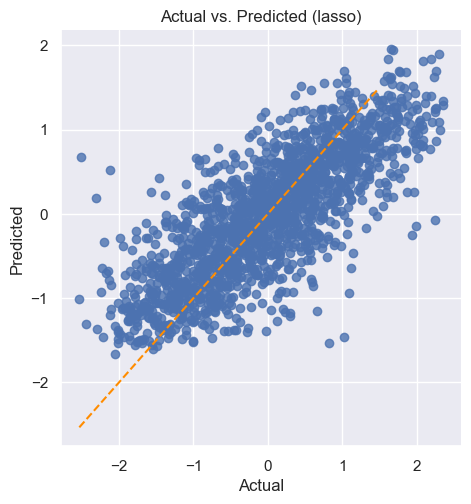

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


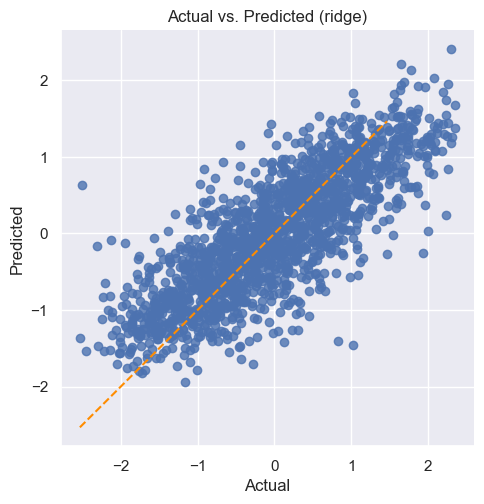

In [298]:
linear_assumption(lasso, X_train, y_train, 'lasso')
linear_assumption(ridge_, X_train, y_train, 'ridge')

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 2.491333294019578e-09
Residuals are not normally distributed


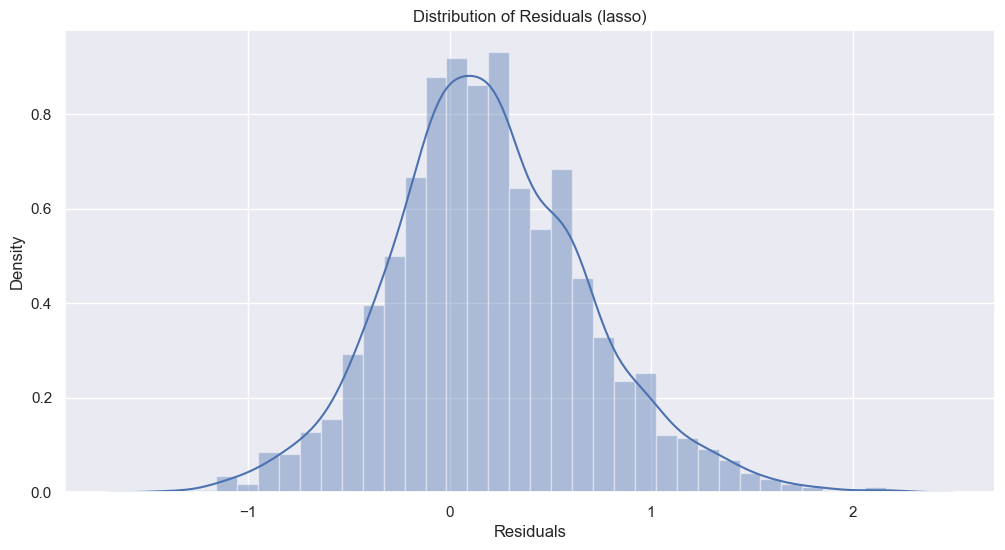


Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0009112643681674289
Residuals are not normally distributed


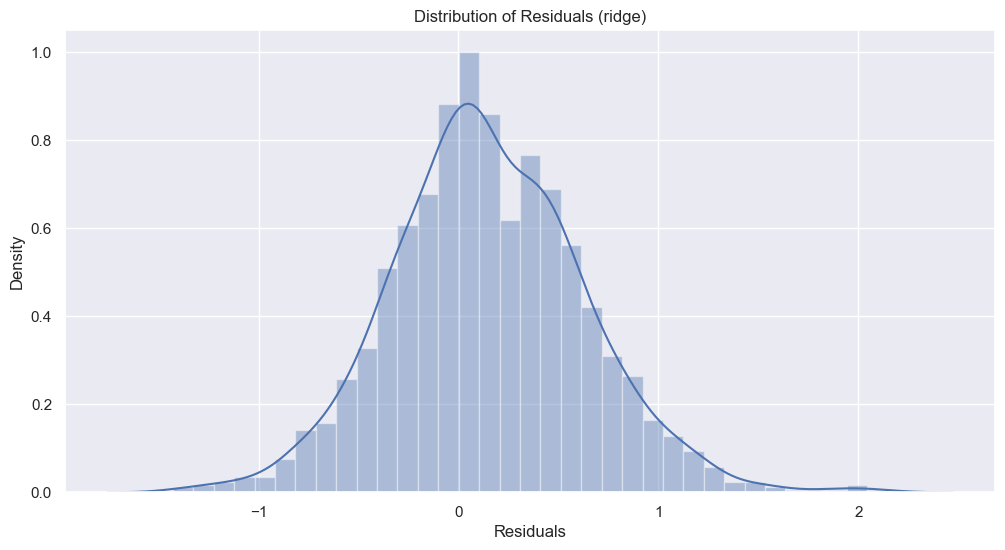

'Assumption not satisfied. Confidence intervals will likely be affected. Try performing nonlinear transformations on variables.'

In [299]:
%%capture --no-display --no-stdout
normal_errors_assumption(lasso, X_train, y_train, 'lasso')
normal_errors_assumption(ridge_, X_train, y_train, 'ridge')

**Model Selection and Justification:**
We chose to use a LASSO regression model in order to combine variable selection and model fitting into one step. We tinkered with the hyperparameters (```alpha``` and ```max_iter``` in sklearn's ```linear_model.Lasso()``` function) to make sure that it dropped covariates that were highly correlated as a way of reducing multicollinearity, and also so that the estimators would converge. We fit ridge regression and generic linear models to the data as well, but since neither dropped any covariates, it would likely lead to higher levels of multicollinearity that could affect predictions in a negative way. Both of those two models had slightly higher $R^2$ values, but the gains in $R^2$ were negligible and did not justify the increased risk of strong multicollinearity. The plots above show the distribution of the residuals along with the results of an Anderson-Darling test for normality and the associated suggestions on how to proceed. While the A-D test says that the data fails to follow a normal distribution, the plots of the residuals show a relatively normal distribution with just a slight skew to the right, and the plots of actual vs. predicted residuals show that the linear model fits the data pretty well.